In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import math

In [8]:
data = pd.read_csv('../data/train.csv', sep=';')
columns = data.columns

In [9]:
columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'SGR', 'NPHI', 'PEF',
       'DTC', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC',
       'ROPA', 'RXO', 'FORCE_2020_LITHOFACIES_LITHOLOGY',
       'FORCE_2020_LITHOFACIES_CONFIDENCE'],
      dtype='object')

In [10]:
grouped = data.groupby('WELL')

In [11]:
nrows = int(math.ceil(len(grouped)/8.))

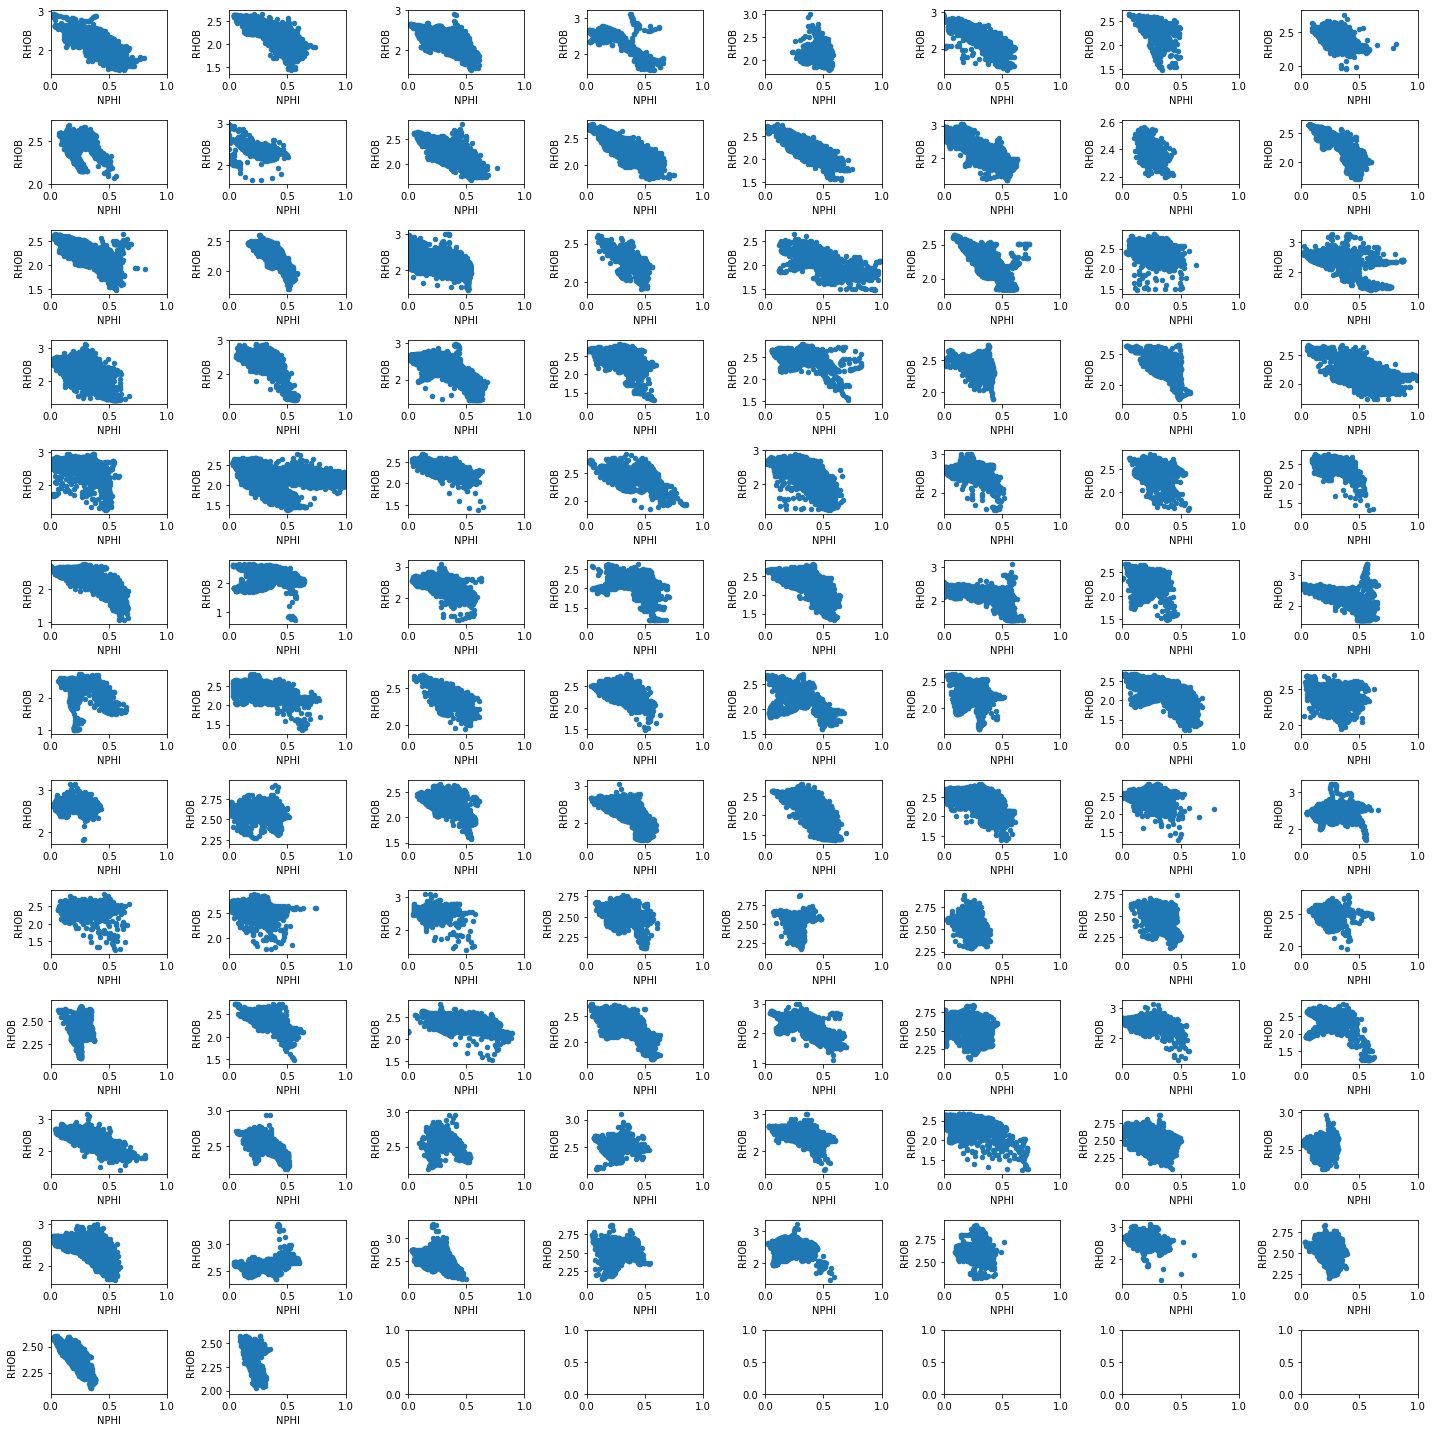

In [12]:
fig, axs = plt.subplots(nrows, 8, figsize=(20,20))
for (name, df), ax in zip(grouped, axs.flat):
    df.plot(kind='scatter', x='NPHI', y='RHOB', ax=ax)
    ax.set_xlim(0,1)
plt.tight_layout()

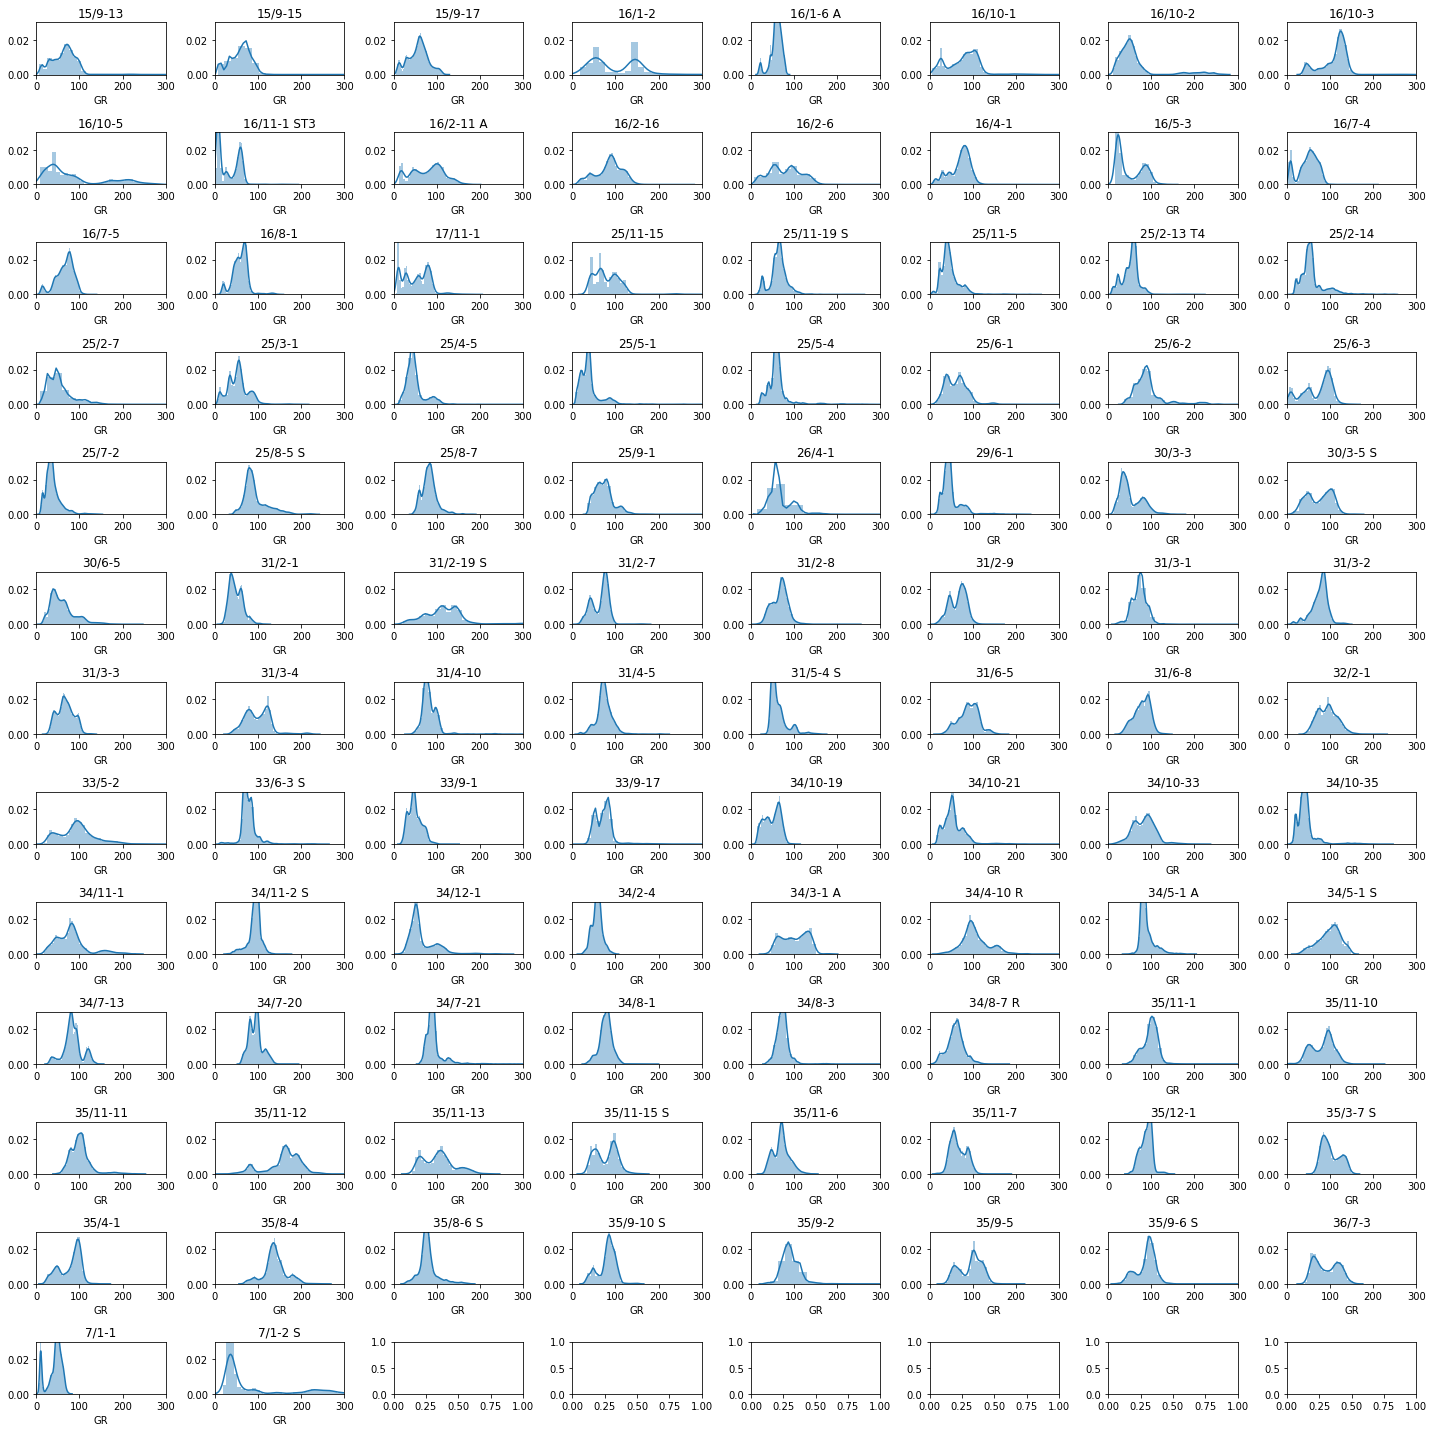

In [15]:
fig, axs = plt.subplots(nrows, 8, figsize=(20,20))
for (name, df), ax in zip(grouped, axs.flat):
    sns.distplot(df['GR'], ax=ax)
    ax.set_xlim(0,300)
    ax.set_ylim(0,0.03)
    ax.set_title(name)
plt.tight_layout()


In [9]:
data[data['GR'] > 300].count()

WELL                                 960
DEPTH_MD                             960
X_LOC                                957
Y_LOC                                957
Z_LOC                                957
GROUP                                960
FORMATION                            957
CALI                                 953
RSHA                                 930
RMED                                 957
RDEP                                 957
RHOB                                 939
GR                                   960
SGR                                   12
NPHI                                 933
PEF                                  838
DTC                                  920
SP                                   902
BS                                   902
ROP                                  167
DTS                                  705
DCAL                                 783
DRHO                                 936
MUDWEIGHT                            136
RMIC            

## PEF Data

In [21]:
pef_df = data.loc[:,['WELL','PEF']]

In [22]:
grouped = pef_df.groupby('WELL')

In [24]:
grouped.dropna(inplace=True)

AttributeError: Cannot access callable attribute 'dropna' of 'DataFrameGroupBy' objects, try using the 'apply' method

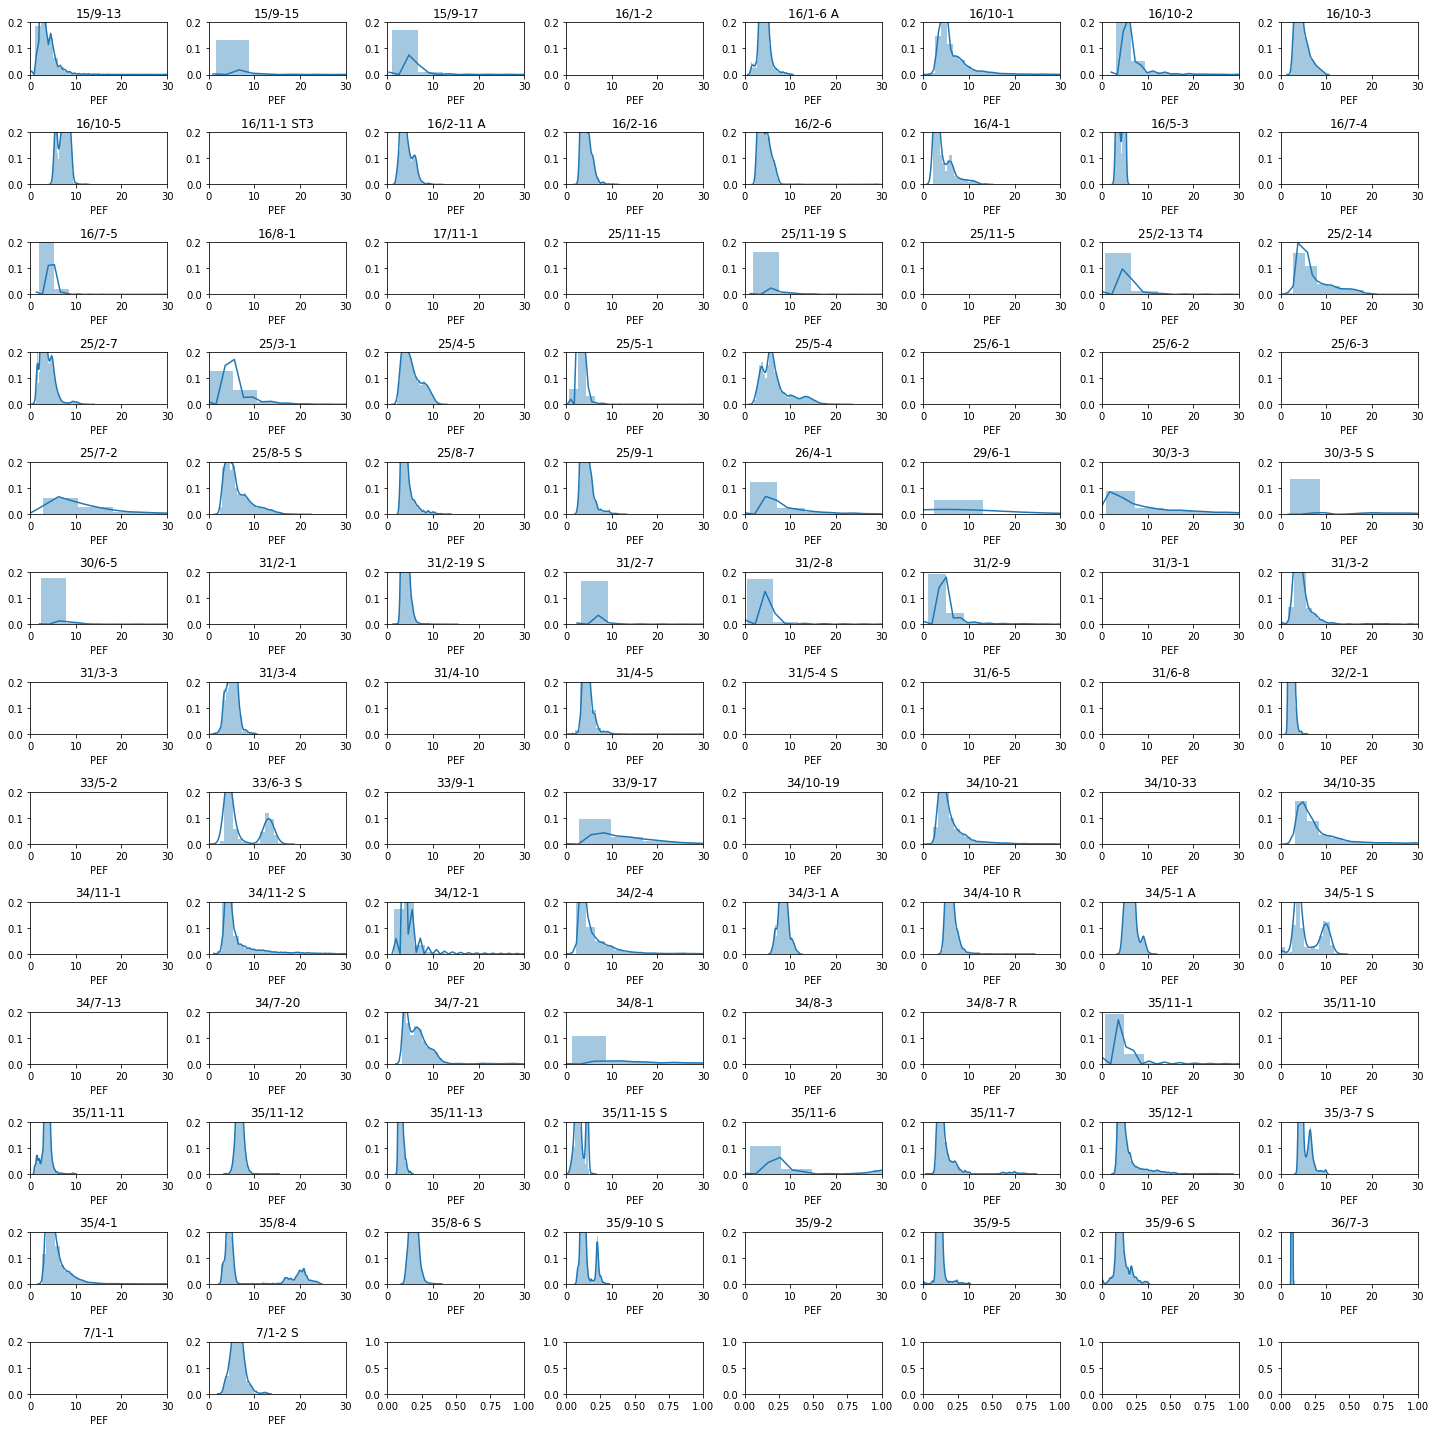

In [27]:
fig, axs = plt.subplots(nrows, 8, figsize=(20,20))
for (name, df), ax in zip(grouped, axs.flat):
    sns.distplot(df['PEF'].dropna(), ax=ax)
    ax.set_xlim(0,30)
    ax.set_ylim(0,0.2)
    ax.set_title(name)
plt.tight_layout()


Well 35/9-5 appears to have a nice bimodal distribution. We will use this as the reference well

## Calculate GR Normalised and VShale

In [10]:
percentile_05 = data.groupby('WELL')['GR'].quantile(0.05)
data['05_PERC'] = data['WELL'].map(percentile_05)
percentile_95 = data.groupby('WELL')['GR'].quantile(0.95)
data['95_PERC'] = data['WELL'].map(percentile_95)



In [11]:
data.loc[data['WELL']=='35/9-5', '95_PERC']

1130566    131.688494
1130567    131.688494
1130568    131.688494
1130569    131.688494
1130570    131.688494
              ...    
1135503    131.688494
1135504    131.688494
1135505    131.688494
1135506    131.688494
1135507    131.688494
Name: 95_PERC, Length: 4942, dtype: float64

In [12]:
data.loc[data['WELL']=='35/9-5', '05_PERC']

1130566    50.822391
1130567    50.822391
1130568    50.822391
1130569    50.822391
1130570    50.822391
             ...    
1135503    50.822391
1135504    50.822391
1135505    50.822391
1135506    50.822391
1135507    50.822391
Name: 05_PERC, Length: 4942, dtype: float64

In [13]:
def normalise(curve, ref_low, ref_high, well_low, well_high):
    
    norm = ref_low + ((ref_high - ref_low) * ((curve - well_low) / (well_high - well_low)))
    return norm

In [14]:
key_well_low = 50.822391
key_well_high = 131.688494
data['GR_NORM'] = data.apply(lambda x: normalise(x['GR'], key_well_low, key_well_high, x['05_PERC'], x['95_PERC']), axis=1)


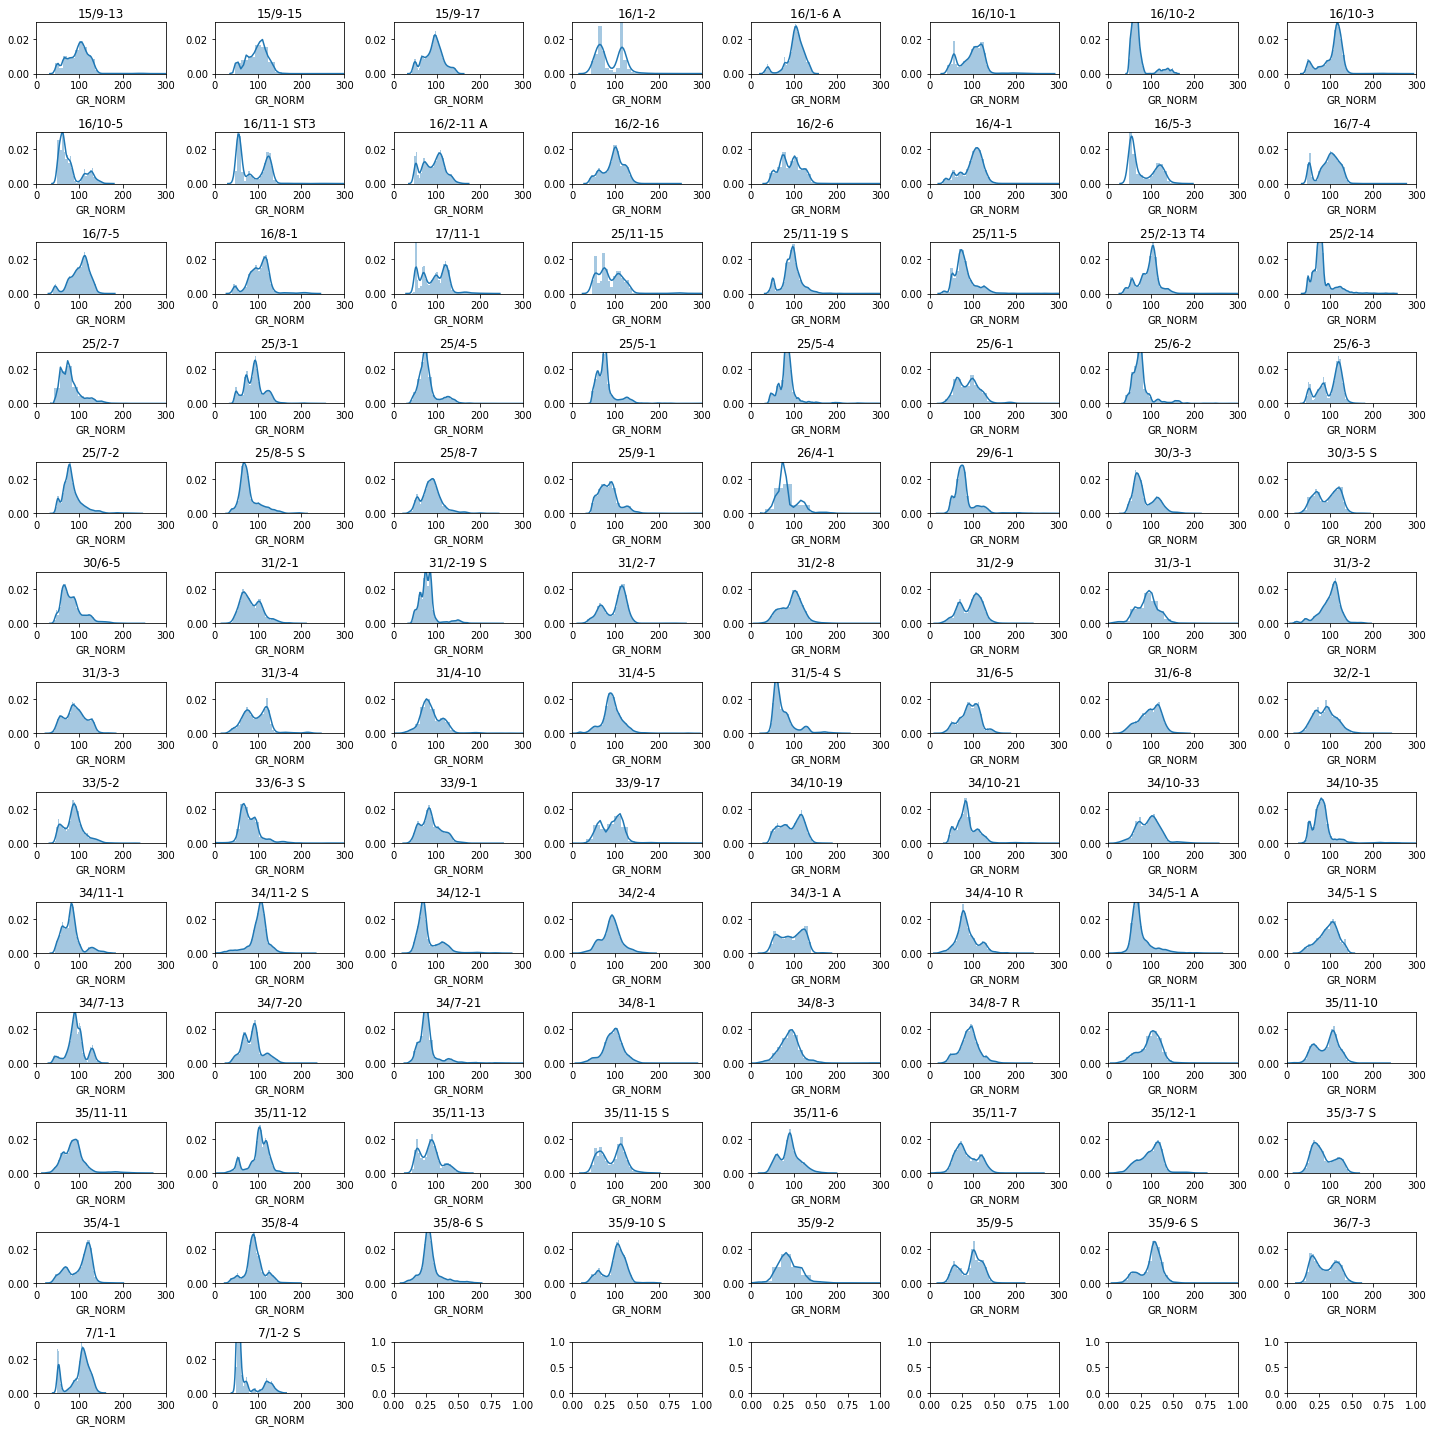

In [15]:
fig, axs = plt.subplots(nrows, 8, figsize=(20,20))
for (name, df), ax in zip(grouped, axs.flat):
    sns.distplot(df['GR_NORM'], ax=ax)
    ax.set_xlim(0,300)
    ax.set_ylim(0,0.03)
    ax.set_title(name)
plt.tight_layout()



In [16]:
def vol_shale(clean, shale, curve):
    vshale = (curve - clean) / (shale - clean)
    if vshale > 1:
        vshale = 1

    if vshale < 0:
        vshale = 0
    
    return vshale

In [17]:
data.describe()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE,05_PERC,95_PERC,GR_NORM
count,1.170511e+06,1.159736e+06,1.159736e+06,1.159736e+06,1.082634e+06,630650.000000,1.131518e+06,1.159496e+06,1.009242e+06,1.170511e+06,...,987857.000000,316151.000000,176160.000000,192325.000000,327427.000000,1.170511e+06,1.170332e+06,1.170511e+06,1.170511e+06,1.170511e+06
mean,2.184087e+03,4.856310e+05,6.681276e+06,-2.138527e+03,1.318568e+01,10.694664,4.986978e+00,1.069103e+01,2.284987e+00,7.091370e+01,...,0.012196,1.216329,7.796809,23.505069,-95.779496,6.138598e+04,1.164258e+00,3.500146e+01,1.099575e+02,9.006886e+01
std,9.971821e+02,3.455641e+04,1.281524e+05,9.709426e+02,3.798907e+00,100.642597,5.467269e+01,1.139480e+02,2.532835e-01,3.423149e+01,...,7.477798,10.180834,89.741807,22.632800,348.980030,1.389170e+04,4.451180e-01,1.864530e+01,3.358997e+01,2.806785e+01
min,1.360860e+02,4.268988e+05,6.406641e+06,-5.395563e+03,2.344000e+00,0.000100,-8.418695e-03,3.170056e-02,7.209712e-01,1.092843e-01,...,-7429.338867,0.125818,0.056586,-999.250122,-999.900024,3.000000e+04,1.000000e+00,4.233289e+00,6.379939e+01,-3.858309e+01
25%,1.418597e+03,4.547996e+05,6.591327e+06,-2.811502e+03,9.429712e+00,0.854120,9.140862e-01,9.102396e-01,2.092203e+00,4.762722e+01,...,-0.009253,0.143792,0.891272,11.281895,0.687681,6.500000e+04,1.000000e+00,1.965328e+01,9.368830e+01,6.992794e+01
50%,2.076605e+03,4.769203e+05,6.737311e+06,-2.042785e+03,1.255575e+01,1.399020,1.443584e+00,1.439000e+00,2.321228e+00,6.836763e+01,...,0.001752,0.155774,1.967156,20.131153,1.366672,6.500000e+04,1.000000e+00,3.220425e+01,1.026740e+02,8.782064e+01
75%,2.864393e+03,5.201532e+05,6.784886e+06,-1.391866e+03,1.671075e+01,3.099348,2.680930e+00,2.557220e+00,2.488580e+00,8.903551e+01,...,0.021702,1.168307,5.084564,31.138481,3.420790,6.500000e+04,1.000000e+00,4.594741e+01,1.198813e+02,1.087333e+02
max,5.436632e+03,5.726328e+05,6.856661e+06,-1.110860e+02,2.827900e+01,2193.904541,1.988616e+03,1.999887e+03,3.457820e+00,1.076964e+03,...,2.836938,185.730927,10000.000000,742.797852,35930.671875,9.900000e+04,3.000000e+00,8.994449e+01,2.848059e+02,1.136846e+03


In [18]:
data.groupby('WELL')['GR_NORM'].quantile(0.05)

WELL
15/9-13     50.822391
15/9-15     50.822391
15/9-17     50.822391
16/1-2      50.822391
16/1-6 A    50.822391
              ...    
35/9-5      50.822391
35/9-6 S    50.822391
36/7-3      50.822391
7/1-1       50.822391
7/1-2 S     50.822391
Name: GR_NORM, Length: 98, dtype: float64

In [19]:
data.groupby('WELL')['GR_NORM'].quantile(0.95)

WELL
15/9-13     131.688494
15/9-15     131.688494
15/9-17     131.688494
16/1-2      131.688494
16/1-6 A    131.688494
               ...    
35/9-5      131.688494
35/9-6 S    131.688494
36/7-3      131.688494
7/1-1       131.688494
7/1-2 S     131.688494
Name: GR_NORM, Length: 98, dtype: float64

In [20]:
data['VSHALE'] = data.apply(lambda x: vol_shale(50.822391, 131.688494, x['GR_NORM']), axis=1)

## Lithology Crossplots

In [73]:
data['DTC'].min()

#

7.415132045700001

In [72]:
data['DTC'].max()

320.47888184

In [30]:
lithology_numbers = {30000: 'Sandstone',
                 65030: 'Sandstone/Shale',
                 65000: 'Shale',
                 80000: 'Marl',
                 74000: 'Dolomite',
                 70000: 'Limestone',
                 70032: 'Chalk',
                 88000: 'Halite',
                 86000: 'Anhydrite',
                 99000: 'Tuff',
                 90000: 'Coal',
                 93000: 'Basement'}

In [31]:
data['LITH'] = data['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_numbers)

In [32]:
grouped_lith = data.groupby('LITH')
nrows_lith = int(math.ceil(len(grouped_lith)/4.))

In [33]:
nrows_lith

3

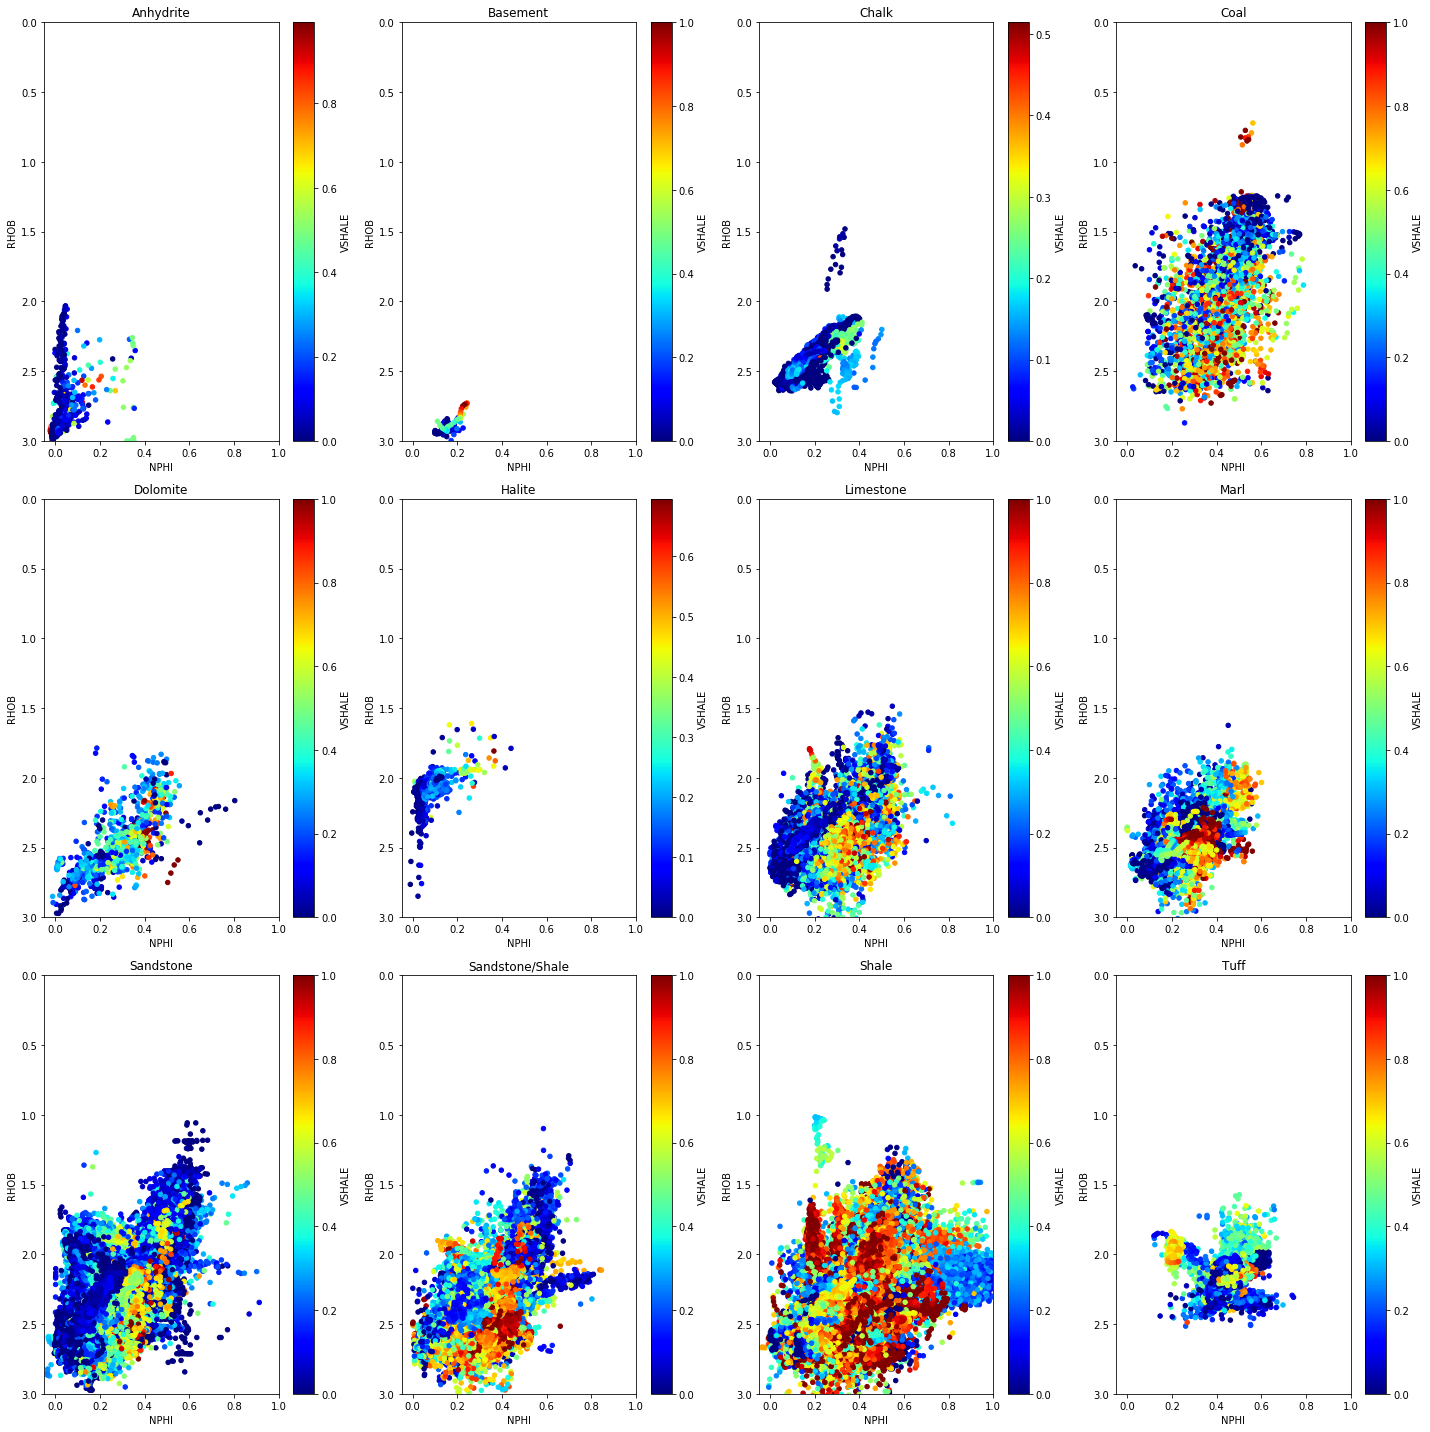

In [59]:
fig, axs = plt.subplots(nrows_lith, 4, figsize=(20,20))
for (name, df), ax in zip(grouped_lith, axs.flat):
    df.plot(kind='scatter', x='NPHI', y='RHOB', c='VSHALE', cmap='jet', ax=ax)
    ax.set_xlim(-0.05,1)
    ax.set_ylim(3,0)
    ax.set_title(name)
plt.tight_layout()

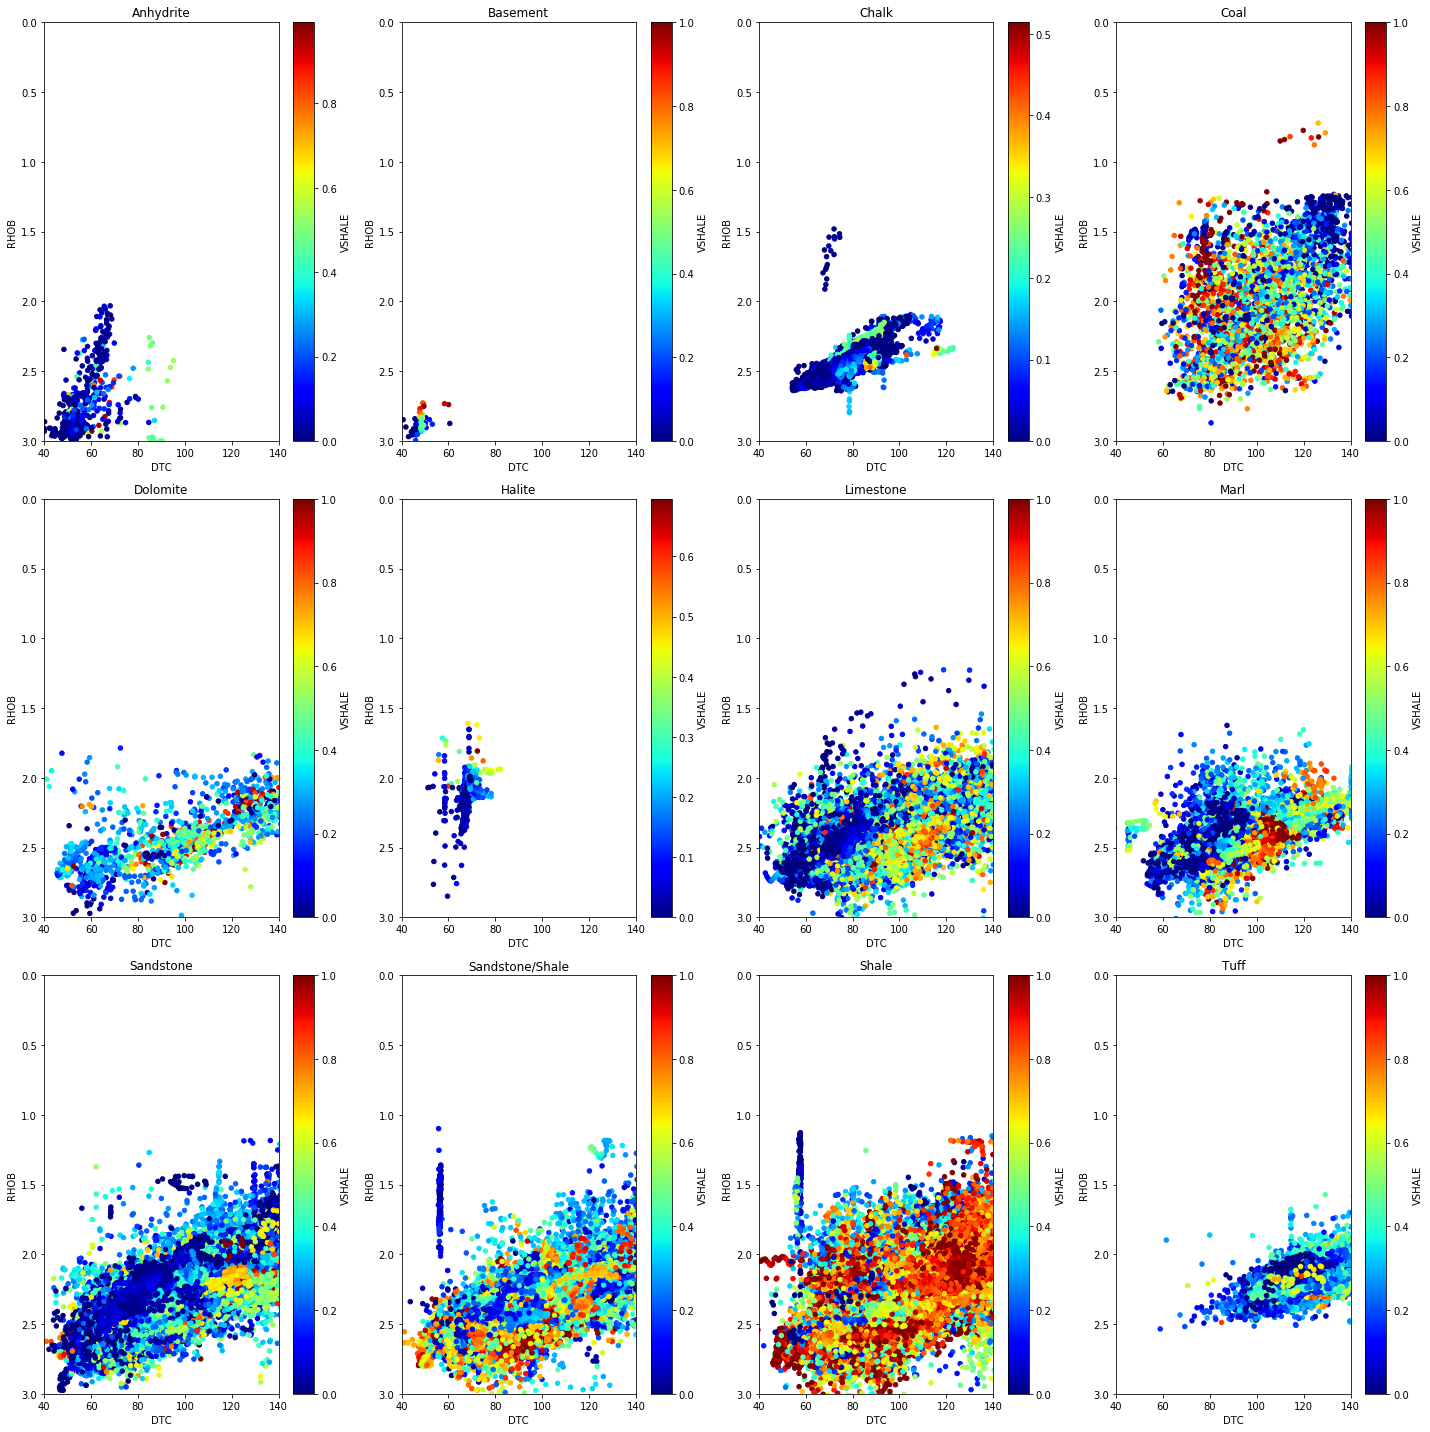

In [63]:
fig, axs = plt.subplots(nrows_lith, 4, figsize=(20,20))
for (name, df), ax in zip(grouped_lith, axs.flat):
    df.plot(kind='scatter', x='DTC', y='RHOB', c='VSHALE', cmap='jet', ax=ax)
    ax.set_xlim(40,140)
    ax.set_ylim(3,0)
    ax.set_title(name)
plt.tight_layout()

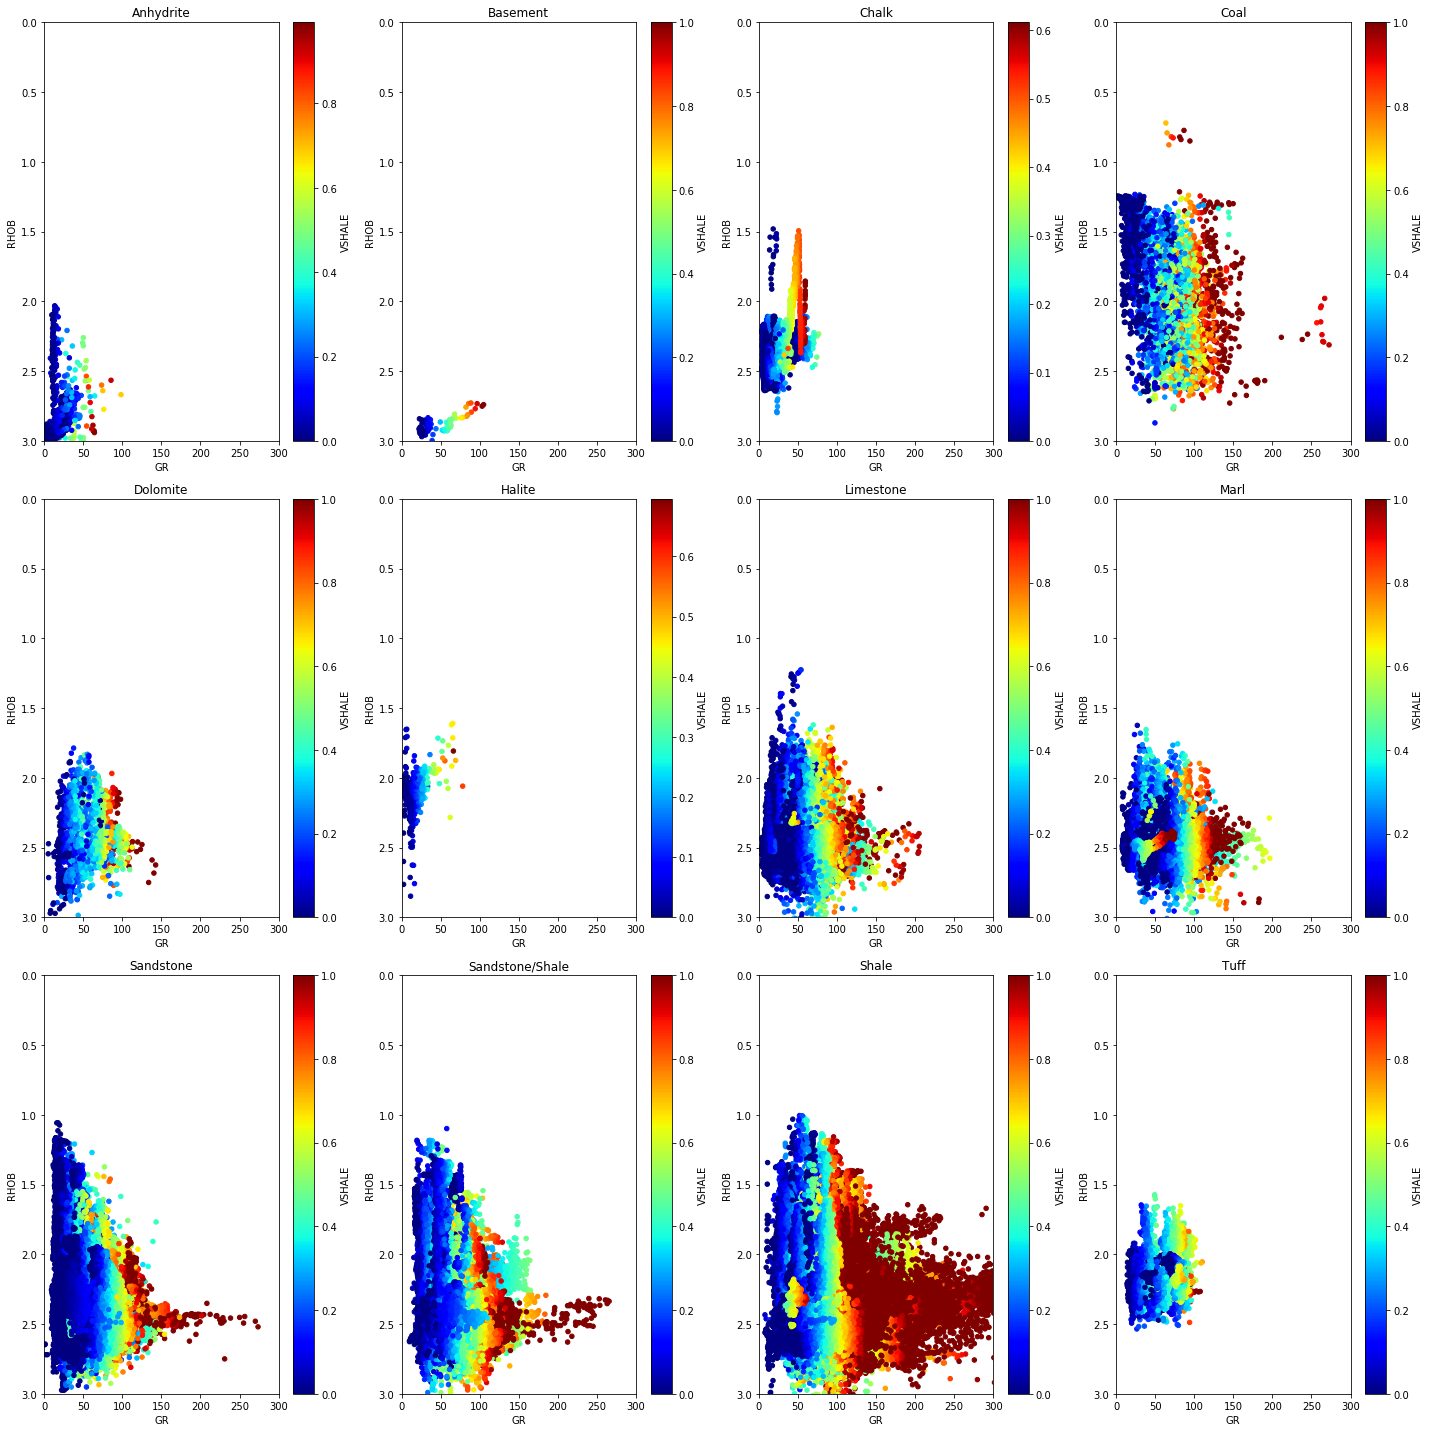

In [64]:
fig, axs = plt.subplots(nrows_lith, 4, figsize=(20,20))
for (name, df), ax in zip(grouped_lith, axs.flat):
    df.plot(kind='scatter', x='GR', y='RHOB', c='VSHALE', cmap='jet', ax=ax)
    ax.set_xlim(0,300)
    ax.set_ylim(3,0)
    ax.set_title(name)
plt.tight_layout()

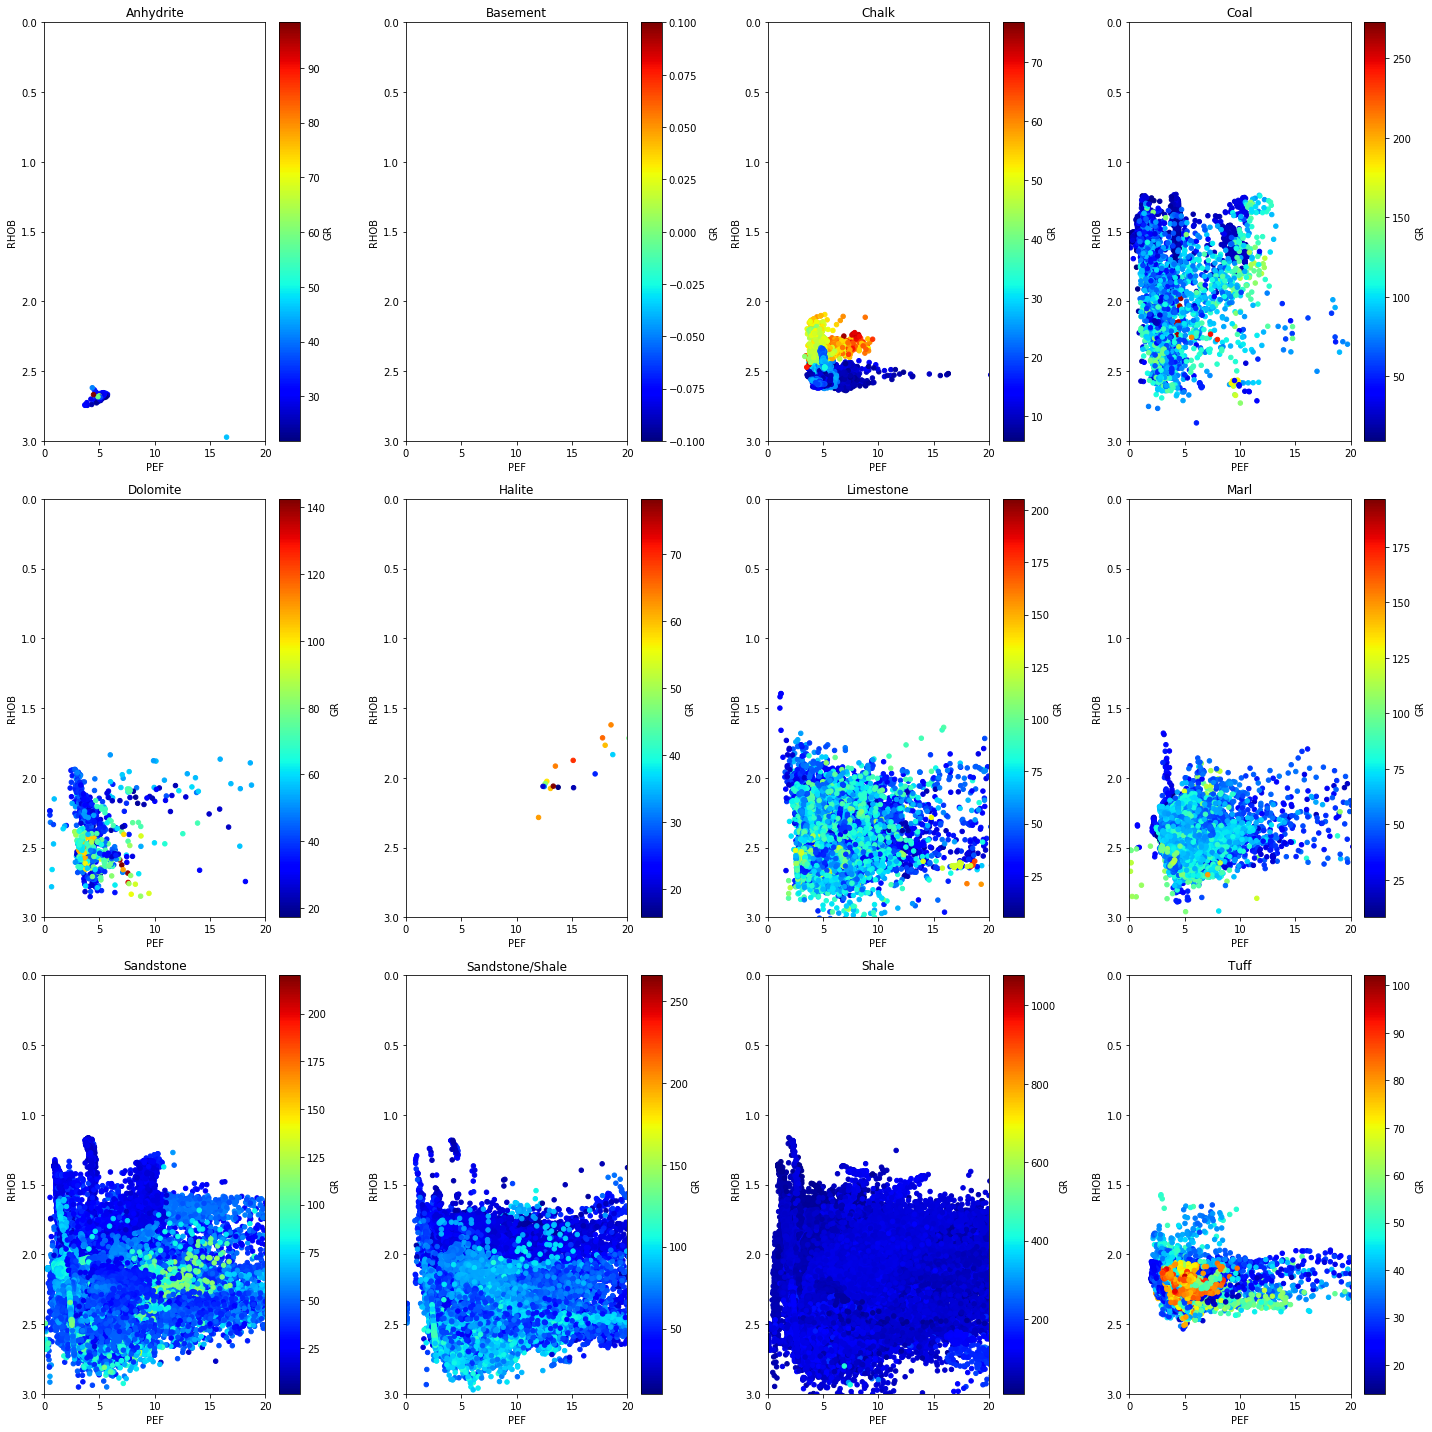

In [35]:
fig, axs = plt.subplots(nrows_lith, 4, figsize=(20,20))
for (name, df), ax in zip(grouped_lith, axs.flat):
    df.plot(kind='scatter', x='PEF', y='RHOB', c='VSHALE', cmap='jet', ax=ax)
    ax.set_xlim(0,20)
    ax.set_ylim(3,0)
    ax.set_title(name)
plt.tight_layout()

In [21]:
data['TVD']= data['Z_LOC']*-1

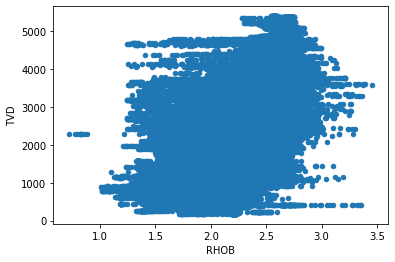

In [22]:
data.plot(kind='scatter', x='RHOB', y='TVD')

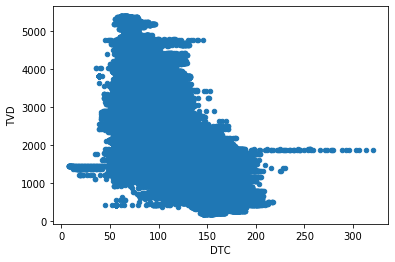

In [23]:
data.plot(kind='scatter', x='DTC', y='TVD')

In [25]:
data_rhob_tvd = data[['TVD', 'RHOB', 'DTC']]

In [26]:
tvd = data_rhob_tvd['TVD']
rhob = data_rhob_tvd['RHOB']

In [27]:
data_rhob_tvd.dropna(inplace=True)

C:\Users\BANAMZ\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
rhob_coeffs = np.polyfit(data_rhob_tvd['TVD'], data_rhob_tvd['RHOB'], 2)

In [30]:
rhob_coeffs

array([-3.14732254e-08,  3.51102253e-04,  1.68427567e+00])

In [29]:
dt_coeffs = np.polyfit(data_rhob_tvd['TVD'], data_rhob_tvd['DTC'], 2)

In [31]:
dt_coeffs

array([ 5.55477517e-06, -5.09347746e-02,  1.92494947e+02])

In [36]:
dummy_tvd = np.linspace(0, 7000, 50)

In [43]:
rhob_trend = (rhob_coeffs[0]*dummy_tvd**2) + (rhob_coeffs[1]*dummy_tvd) + rhob_coeffs[2]

In [47]:
dtc_trend = (dt_coeffs[0]*dummy_tvd**2) + (dt_coeffs[1]*dummy_tvd) + dt_coeffs[2]

In [32]:
data_rhob_tvd['RHOB_TREND'] = (rhob_coeffs[0]*data_rhob_tvd['TVD']**2) + (rhob_coeffs[1]*data_rhob_tvd['TVD']) + rhob_coeffs[2]

C:\Users\BANAMZ\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
data_rhob_tvd['DTC_TREND'] = (dt_coeffs[0]*data_rhob_tvd['TVD']**2) + (dt_coeffs[1]*data_rhob_tvd['TVD']) + dt_coeffs[2]

C:\Users\BANAMZ\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


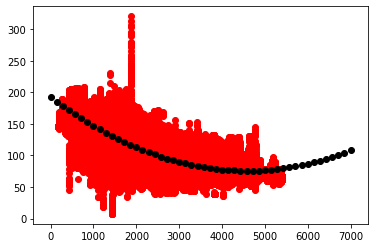

In [48]:
plt.scatter(data_rhob_tvd['TVD'], data_rhob_tvd['DTC'], color='red')
plt.scatter(dummy_tvd, dtc_trend, color='black')
plt.show()

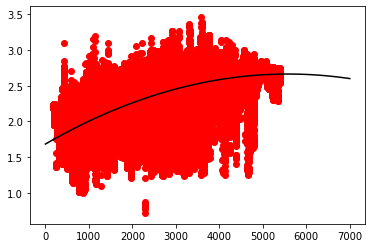

In [46]:
plt.scatter(data_rhob_tvd['TVD'], data_rhob_tvd['RHOB'], color='red')
# plt.scatter(data_rhob_tvd['TVD'], data_rhob_tvd['RHOB_TREND'], color='black')
plt.plot(dummy_tvd, rhob_trend, color='black')
plt.show()

In [115]:
type(rhob_trend)

numpy.ndarray

In [116]:
type(tvd_dummy)

numpy.ndarray

In [1]:
dt_coeffs

NameError: name 'dt_coeffs' is not defined

In [152]:
data_rhob_tvd['RHOB_TREND'] 

0          1.842181
1          1.842230
2          1.842279
3          1.842328
4          1.842377
             ...   
1170442    2.470036
1170443    2.470060
1170444    2.470084
1170445    2.470107
1170446    2.470131
Name: RHOB_TREND, Length: 963653, dtype: float64

# Gardner's Equation

In [50]:
def gardners_equation_rhob(curve):
    """Simplified Gardners Equation

    Parameters
    ----------
    curve :
        Compressional Slowness

    Returns
    -------
    float
        Computed RHOB from Gardner's Equation
    """
    a_metric = 0.31 #m/s
    a_imperial = 0.23 #ft/s
    b = 0.25
    
    vp = 1000000 / curve 
    rhob = a_imperial * (vp** b)

    return rhob

In [52]:
data_rhob_tvd['RHOB_GARD'] = data_rhob_tvd.apply(lambda x: gardners_equation_rhob(x.loc['DTC']), axis=1)

C:\Users\BANAMZ\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


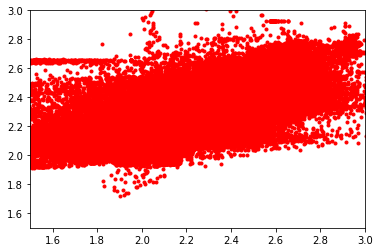

In [55]:
plt.scatter(data_rhob_tvd['RHOB'], data_rhob_tvd['RHOB_GARD'], color='red', marker='.')
plt.xlim(1.5, 3)
plt.ylim(1.5,3)
plt.show()

In [60]:
data_rhob_tvd['RHOB_FIX'] = data_rhob_tvd['RHOB']
data_rhob_tvd['RHOB_FIX'].fillna(data_rhob_tvd['RHOB_GARD'], inplace=True)


C:\Users\BANAMZ\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


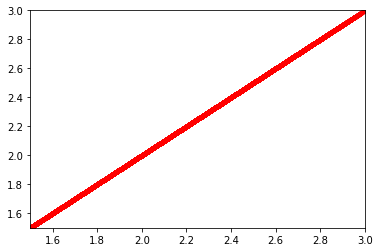

In [61]:
plt.scatter(data_rhob_tvd['RHOB'], data_rhob_tvd['RHOB_FIX'], color='red', marker='.')
plt.xlim(1.5, 3)
plt.ylim(1.5 ,3)
plt.show()


In [58]:
data_rhob_tvd.head()

,TVD,RHOB,DTC,RHOB_TREND,DTC_TREND,RHOB_GARD,RHOB_FIX
0,469.501831,1.884186,161.131180,1.842181,169.805427,2.041423,None
1,469.653809,1.889794,160.603470,1.842230,169.798479,2.043098,None
2,469.805786,1.896523,160.173615,1.842279,169.791531,2.044467,None
3,469.957794,1.891913,160.149429,1.842328,169.784582,2.044544,None
4,470.109772,1.880034,160.128342,1.842377,169.777634,2.044611,None
